In [2]:
import json
import matplotlib.pyplot as plt
import requests
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

In [55]:

# API key - get yours from https://the-odds-api.com
API_KEY = KEY


def fetch_historical_odds(sport, date):
    """Get historical odds from The Odds API for a specific date"""
    
    url = f"https://api.the-odds-api.com/v4/historical/sports/{sport}/odds"
    
    params = {
        "apiKey": API_KEY,
        "regions": "us",      # US sportsbooks only
        "markets": "h2h",     # moneyline odds
        "date": date
    }
    
    r = requests.get(url, params=params, timeout=15)
    return r.json()


def fetch_season(start_date, weeks=22):
    """
    Fetch full NFL season data, one week at a time.
    
    NFL has 18 regular season weeks + 4 playoff weeks = 22 total.
    We grab data once per week to save API credits.
    """
    
    all_games = []
    current = start_date
    
    # loop through each week of the season
    for week in range(weeks):
        
        # format date for API
        date_str = current.strftime("%Y-%m-%dT18:00:00Z")
        print(f"Week {week+1}: {date_str[:10]}", end=" - ")
        
        # call API
        result = fetch_historical_odds("americanfootball_nfl", date_str)
        
        # check response and add games to list
        if isinstance(result, dict) and "data" in result:
            games = result["data"]
            all_games.extend(games)
        else:
            print("no data")
            return None
        
        # move to next week
        current += timedelta(days=7)
    
    return all_games


# Fetch 5 seasons

# 2020-21 season
print("2020-21 Season")
games_2020 = fetch_season(datetime(2020, 9, 10), weeks=22)
print(f"Total: {len(games_2020)} games\n")

# 2021-22 season
print("2021-22 Season")
games_2021 = fetch_season(datetime(2021, 9, 9), weeks=22)
print(f"Total: {len(games_2021)} games\n")

# 2022-23 season
print("2022-23 Season")
games_2022 = fetch_season(datetime(2022, 9, 8), weeks=22)
print(f"Total: {len(games_2022)} games\n")

# 2023-24 season
print("2023-24 Season")
games_2023 = fetch_season(datetime(2023, 9, 7), weeks=22)
print(f"Total: {len(games_2023)} games\n")

# 2024-25 season
print("2024-25 Season")
games_2024 = fetch_season(datetime(2024, 9, 5), weeks=22)
print(f"Total: {len(games_2024)} games\n")

2020-21 Season
Week 1: 2020-09-10 - Week 2: 2020-09-17 - Week 3: 2020-09-24 - Week 4: 2020-10-01 - Week 5: 2020-10-08 - Week 6: 2020-10-15 - Week 7: 2020-10-22 - Week 8: 2020-10-29 - Week 9: 2020-11-05 - Week 10: 2020-11-12 - Week 11: 2020-11-19 - Week 12: 2020-11-26 - Week 13: 2020-12-03 - Week 14: 2020-12-10 - Week 15: 2020-12-17 - Week 16: 2020-12-24 - Week 17: 2020-12-31 - Week 18: 2021-01-07 - Week 19: 2021-01-14 - Week 20: 2021-01-21 - Week 21: 2021-01-28 - Week 22: 2021-02-04 - Total: 380 games

2021-22 Season
Week 1: 2021-09-09 - Week 2: 2021-09-16 - Week 3: 2021-09-23 - Week 4: 2021-09-30 - Week 5: 2021-10-07 - Week 6: 2021-10-14 - Week 7: 2021-10-21 - Week 8: 2021-10-28 - Week 9: 2021-11-04 - Week 10: 2021-11-11 - Week 11: 2021-11-18 - Week 12: 2021-11-25 - Week 13: 2021-12-02 - Week 14: 2021-12-09 - Week 15: 2021-12-16 - Week 16: 2021-12-23 - Week 17: 2021-12-30 - Week 18: 2022-01-06 - Week 19: 2022-01-13 - Week 20: 2022-01-20 - Week 21: 2022-01-27 - Week 22: 2022-02-03 - To

In [54]:
KEY=

In [56]:
# save to files
json.dump(games_2020, open("games_2020.json", "w"))
json.dump(games_2021, open("games_2021.json", "w"))
json.dump(games_2022, open("games_2022.json", "w"))
json.dump(games_2023, open("games_2023.json", "w"))
json.dump(games_2024, open("games_2024.json", "w"))
print("Data saved!")

Data saved!


In [3]:
# Load saved odds data (no API calls here)
with open("games_2020.json", "r") as f:
    games_2020 = json.load(f)

with open("games_2021.json", "r") as f:
    games_2021 = json.load(f)

with open("games_2022.json", "r") as f:
    games_2022 = json.load(f)

with open("games_2023.json", "r") as f:
    games_2023 = json.load(f)

with open("games_2024.json", "r") as f:
    games_2024 = json.load(f)

print("All 5 seasons loaded from local JSON!")

All 5 seasons loaded from local JSON!


In [4]:
def games_to_dataframe(games):
    """Convert raw API data to a clean DataFrame"""
    
    rows = []
    
    for game in games:
        home = game.get("home_team")
        away = game.get("away_team")
        time = game.get("commence_time")
        
        # loop through each bookmaker (DraftKings, FanDuel, etc.)
        for book in game.get("bookmakers", []):
            book_name = book.get("key")
            
            # get h2h (moneyline) market
            for market in book.get("markets", []):
                if market.get("key") == "h2h":
                    home_odds = None
                    away_odds = None
                    
                    # extract odds for home and away team
                    for outcome in market.get("outcomes", []):
                        if outcome["name"] == home:
                            home_odds = outcome["price"]
                        else:
                            away_odds = outcome["price"]
                    
                    # add row to our list
                    rows.append({
                        "game_time": time,
                        "home_team": home,
                        "away_team": away,
                        "bookmaker": book_name,
                        "home_odds": home_odds,
                        "away_odds": away_odds
                    })
    
    return pd.DataFrame(rows)

all_games = (
    games_2020
    + games_2021
    + games_2022
    + games_2023
    + games_2024
)
# convert all 5 seasons to one DataFrame
all_df = games_to_dataframe(all_games)

# check results
print("All data (5 years):", all_df.shape)
print("\nSample:")
all_df.head(10)


All data (5 years): (25469, 6)

Sample:


,game_time,home_team,away_team,bookmaker,home_odds,away_odds
0,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,unibet,1.35,3.25
1,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,betonlineag,1.33,3.50
2,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,lowvig,1.33,3.50
3,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,pointsbetus,1.33,3.40
4,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,gtbets,1.33,3.55
5,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,bookmaker,1.34,3.41
6,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,betfair,1.38,3.50
7,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,mybookieag,1.33,3.50
8,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,draftkings,1.35,3.25
9,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,fanduel,1.34,3.35


In [5]:

# Check 5-year combined data

print("All data shape (5 years):", all_df.shape)

print("\nMissing values:")
print(all_df.isnull().sum())

print("\nSample odds range:")
print(f"Home odds: {all_df['home_odds'].min():.2f} - {all_df['home_odds'].max():.2f}")
print(f"Away odds: {all_df['away_odds'].min():.2f} - {all_df['away_odds'].max():.2f}")

All data shape (5 years): (25469, 6)

Missing values:
game_time    0
home_team    0
away_team    0
bookmaker    0
home_odds    0
away_odds    0
dtype: int64

Sample odds range:
Home odds: 1.00 - 10.00
Away odds: 1.00 - 15.00


In [6]:
def fetch_nfl_results_silent(season):
    """
    Fetch NFL regular season + playoffs results from ESPN.
    """
    results = []
    
    # Regular season: weeks 1-18, seasontype=2
    for week in range(1, 19):
        url = "https://site.api.espn.com/apis/site/v2/sports/football/nfl/scoreboard"
        params = {"dates": season, "week": week, "seasontype": 2}
        r = requests.get(url, params=params, timeout=15)
        data = r.json()
        
        for game in data.get("events", []):
            comp = game.get("competitions", [{}])[0]
            teams = comp.get("competitors", [])
            if len(teams) == 2:
                home = next((t for t in teams if t["homeAway"] == "home"), None)
                away = next((t for t in teams if t["homeAway"] == "away"), None)
                if home and away:
                    game_date = game.get("date", "")[:10]
                    results.append({
                        "game_date": game_date,
                        "home_team": home["team"]["displayName"],
                        "away_team": away["team"]["displayName"],
                        "home_score": int(home.get("score", 0)),
                        "away_score": int(away.get("score", 0))
                    })
    
    # Playoffs: weeks 1-4, seasontype=3
    for week in range(1, 5):
        url = "https://site.api.espn.com/apis/site/v2/sports/football/nfl/scoreboard"
        params = {"dates": season, "week": week, "seasontype": 3}
        r = requests.get(url, params=params, timeout=15)
        data = r.json()
        
        for game in data.get("events", []):
            comp = game.get("competitions", [{}])[0]
            teams = comp.get("competitors", [])
            if len(teams) == 2:
                home = next((t for t in teams if t["homeAway"] == "home"), None)
                away = next((t for t in teams if t["homeAway"] == "away"), None)
                if home and away:
                    game_date = game.get("date", "")[:10]
                    results.append({
                        "game_date": game_date,
                        "home_team": home["team"]["displayName"],
                        "away_team": away["team"]["displayName"],
                        "home_score": int(home.get("score", 0)),
                        "away_score": int(away.get("score", 0))
                    })
    
    return pd.DataFrame(results)

# fetch all seasons
results_2020 = fetch_nfl_results_silent(2020)
results_2021 = fetch_nfl_results_silent(2021)
results_2022 = fetch_nfl_results_silent(2022)
results_2023 = fetch_nfl_results_silent(2023)
results_2024 = fetch_nfl_results_silent(2024)

# combine all seasons
all_results_df = pd.concat(
    [results_2020, results_2021, results_2022, results_2023, results_2024],
    ignore_index=True
)
print("All results shape (5 years with playoffs):", all_results_df.shape)
all_results_df.head()


All results shape (5 years with playoffs): (1409, 5)


,game_date,home_team,away_team,home_score,away_score
0,2020-09-11,Kansas City Chiefs,Houston Texans,34,20
1,2020-09-13,Atlanta Falcons,Seattle Seahawks,25,38
2,2020-09-13,Buffalo Bills,New York Jets,27,17
3,2020-09-13,Detroit Lions,Chicago Bears,23,27
4,2020-09-13,Minnesota Vikings,Green Bay Packers,34,43


In [7]:
# fix ESPN team names
team_name_map = {
    "Washington": "Washington Commanders",
    "Washington Football Team": "Washington Commanders"
}

all_results_df["home_team"] = all_results_df["home_team"].replace(team_name_map)
all_results_df["away_team"] = all_results_df["away_team"].replace(team_name_map)

print("Fixed! Check Washington names:")
print(all_results_df[all_results_df["home_team"].str.contains("Washington", na=False)]["home_team"].unique())

Fixed! Check Washington names:
['Washington Commanders']


In [8]:
# Determine winner for all seasons (2020–2024)
# If home_score > away_score, home team wins; otherwise away team wins

all_results_df["winner"] = all_results_df.apply(
    lambda x: x["home_team"] if x["home_score"] > x["away_score"] else x["away_team"],
    axis=1
)

# Check sample results
print("All seasons sample:")
print(all_results_df.head(10))


All seasons sample:
    game_date              home_team            away_team  home_score  \
0  2020-09-11     Kansas City Chiefs       Houston Texans          34   
1  2020-09-13        Atlanta Falcons     Seattle Seahawks          25   
2  2020-09-13          Buffalo Bills        New York Jets          27   
3  2020-09-13          Detroit Lions        Chicago Bears          23   
4  2020-09-13      Minnesota Vikings    Green Bay Packers          34   
5  2020-09-13   New England Patriots       Miami Dolphins          21   
6  2020-09-13  Washington Commanders  Philadelphia Eagles          27   
7  2020-09-13      Carolina Panthers    Las Vegas Raiders          30   
8  2020-09-13   Jacksonville Jaguars   Indianapolis Colts          27   
9  2020-09-13       Baltimore Ravens     Cleveland Browns          38   

   away_score                 winner  
0          20     Kansas City Chiefs  
1          38       Seattle Seahawks  
2          17          Buffalo Bills  
3          27       

In [9]:

# convert game_time to game_date format for matching
all_df["game_date"] = all_df["game_time"].str[:10]  # '2023-09-08T00:20:00Z' -> '2023-09-08'

# now merge on game_date instead of game_time
results_for_merge = all_results_df[[
    "game_date",
    "home_team",
    "away_team",
    "home_score",
    "away_score",
    "winner"
]]

all_merged = all_df.merge(
    results_for_merge,
    on=["game_date", "home_team", "away_team"],
    how="left"
)

print("Final merged shape (5 years):", all_merged.shape)
print("\nCheck for missing results:")
print(all_merged["winner"].isna().sum(), "rows without match")
print("\nSample:")
all_merged.head(10)

Final merged shape (5 years): (25469, 10)

Check for missing results:
858 rows without match

Sample:


,game_time,home_team,away_team,bookmaker,home_odds,away_odds,game_date,home_score,away_score,winner
0,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,unibet,1.35,3.25,2020-09-13,27.0,17.0,Buffalo Bills
1,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,betonlineag,1.33,3.50,2020-09-13,27.0,17.0,Buffalo Bills
2,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,lowvig,1.33,3.50,2020-09-13,27.0,17.0,Buffalo Bills
3,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,pointsbetus,1.33,3.40,2020-09-13,27.0,17.0,Buffalo Bills
4,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,gtbets,1.33,3.55,2020-09-13,27.0,17.0,Buffalo Bills
5,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,bookmaker,1.34,3.41,2020-09-13,27.0,17.0,Buffalo Bills
6,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,betfair,1.38,3.50,2020-09-13,27.0,17.0,Buffalo Bills
7,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,mybookieag,1.33,3.50,2020-09-13,27.0,17.0,Buffalo Bills
8,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,draftkings,1.35,3.25,2020-09-13,27.0,17.0,Buffalo Bills
9,2020-09-13T17:00:00Z,Buffalo Bills,New York Jets,fanduel,1.34,3.35,2020-09-13,27.0,17.0,Buffalo Bills


In [10]:
# drop rows without winner
all_merged = all_merged.dropna(subset=["winner"])

print(f"Clean data shape: {all_merged.shape}")

Clean data shape: (24611, 10)


In [11]:
# convert decimal odds to implied probability
all_merged["home_implied_prob"] = 1 / all_merged["home_odds"]
all_merged["away_implied_prob"] = 1 / all_merged["away_odds"]

# check if our bet won
all_merged["home_win"] = (all_merged["winner"] == all_merged["home_team"]).astype(int)
all_merged["away_win"] = (all_merged["winner"] == all_merged["away_team"]).astype(int)

# calculate EV for betting on home team
all_merged["home_bet_ev"] = all_merged["home_implied_prob"] * (all_merged["home_odds"] - 1) - (1 - all_merged["home_implied_prob"]) * 1

print("Sample with EV:")
print(all_merged[["home_team", "away_team", "home_odds", "home_implied_prob", "home_win", "home_bet_ev"]].head(10))

Sample with EV:
       home_team      away_team  home_odds  home_implied_prob  home_win  \
0  Buffalo Bills  New York Jets       1.35           0.740741         1   
1  Buffalo Bills  New York Jets       1.33           0.751880         1   
2  Buffalo Bills  New York Jets       1.33           0.751880         1   
3  Buffalo Bills  New York Jets       1.33           0.751880         1   
4  Buffalo Bills  New York Jets       1.33           0.751880         1   
5  Buffalo Bills  New York Jets       1.34           0.746269         1   
6  Buffalo Bills  New York Jets       1.38           0.724638         1   
7  Buffalo Bills  New York Jets       1.33           0.751880         1   
8  Buffalo Bills  New York Jets       1.35           0.740741         1   
9  Buffalo Bills  New York Jets       1.34           0.746269         1   

    home_bet_ev  
0  0.000000e+00  
1  0.000000e+00  
2  0.000000e+00  
3  0.000000e+00  
4  0.000000e+00  
5 -5.551115e-17  
6  5.551115e-17  
7  0.000000e+0

In [12]:
# step 1: average implied probability across bookmakers (per game)
avg_prob = all_merged.groupby(["game_date", "home_team", "away_team"]).agg({
    "home_implied_prob": "mean",
    "away_implied_prob": "mean"
}).reset_index()

# Rename columns for clarity
avg_prob.columns = ["game_date", "home_team", "away_team", "avg_home_implied", "avg_away_implied"]

# --- THE FIX: REMOVE THE VIG (Normalization) ---
# 1. Calculate the total market probability (usually around 1.04 or 104%)
avg_prob["market_sum"] = avg_prob["avg_home_implied"] + avg_prob["avg_away_implied"]

# 2. Calculate TRUE probabilities by dividing by the market sum
avg_prob["true_home_prob"] = avg_prob["avg_home_implied"] / avg_prob["market_sum"]
avg_prob["true_away_prob"] = avg_prob["avg_away_implied"] / avg_prob["market_sum"]

# step 2: merge back to the main data
all_ev = all_merged.merge(avg_prob, on=["game_date", "home_team", "away_team"])

# step 3: calculate Real EV using the TRUE probability
# EV = (True Probability * Decimal Odds) - 1
all_ev["home_ev"] = (all_ev["true_home_prob"] * all_ev["home_odds"]) - 1
all_ev["away_ev"] = (all_ev["true_away_prob"] * all_ev["away_odds"]) - 1

print("Sample with Real EV (De-vigged):")
print(all_ev[["game_date", "home_team", "bookmaker", "home_odds", "true_home_prob", "home_ev"]].head(10))

Sample with Real EV (De-vigged):
    game_date      home_team    bookmaker  home_odds  true_home_prob   home_ev
0  2020-09-13  Buffalo Bills       unibet       1.35        0.718024 -0.030667
1  2020-09-13  Buffalo Bills  betonlineag       1.33        0.718024 -0.045028
2  2020-09-13  Buffalo Bills       lowvig       1.33        0.718024 -0.045028
3  2020-09-13  Buffalo Bills  pointsbetus       1.33        0.718024 -0.045028
4  2020-09-13  Buffalo Bills       gtbets       1.33        0.718024 -0.045028
5  2020-09-13  Buffalo Bills    bookmaker       1.34        0.718024 -0.037847
6  2020-09-13  Buffalo Bills      betfair       1.38        0.718024 -0.009126
7  2020-09-13  Buffalo Bills   mybookieag       1.33        0.718024 -0.045028
8  2020-09-13  Buffalo Bills   draftkings       1.35        0.718024 -0.030667
9  2020-09-13  Buffalo Bills      fanduel       1.34        0.718024 -0.037847


In [13]:
# check all_ev data
print("All 5 years shape:", all_ev.shape)
print("\nSeasons covered:")
print(all_ev["game_date"].str[:4].value_counts().sort_index())
print("\nSample:")
all_ev[["game_date", "home_team", "bookmaker", "home_ev", "home_win"]].head(10)

All 5 years shape: (24611, 22)

Seasons covered:
game_date
2020    3191
2021    4580
2022    6118
2023    6377
2024    4050
2025     295
Name: count, dtype: int64

Sample:


,game_date,home_team,bookmaker,home_ev,home_win
0,2020-09-13,Buffalo Bills,unibet,-0.030667,1
1,2020-09-13,Buffalo Bills,betonlineag,-0.045028,1
2,2020-09-13,Buffalo Bills,lowvig,-0.045028,1
3,2020-09-13,Buffalo Bills,pointsbetus,-0.045028,1
4,2020-09-13,Buffalo Bills,gtbets,-0.045028,1
5,2020-09-13,Buffalo Bills,bookmaker,-0.037847,1
6,2020-09-13,Buffalo Bills,betfair,-0.009126,1
7,2020-09-13,Buffalo Bills,mybookieag,-0.045028,1
8,2020-09-13,Buffalo Bills,draftkings,-0.030667,1
9,2020-09-13,Buffalo Bills,fanduel,-0.037847,1


=== 5 Years (2020-2025) ===
Home actual win rate: 53.9%
Away actual win rate: 46.1%
Home True Prob (avg): 54.9%
Away True Prob (avg): 45.1%
Sum of True Probabilities: 100.0%


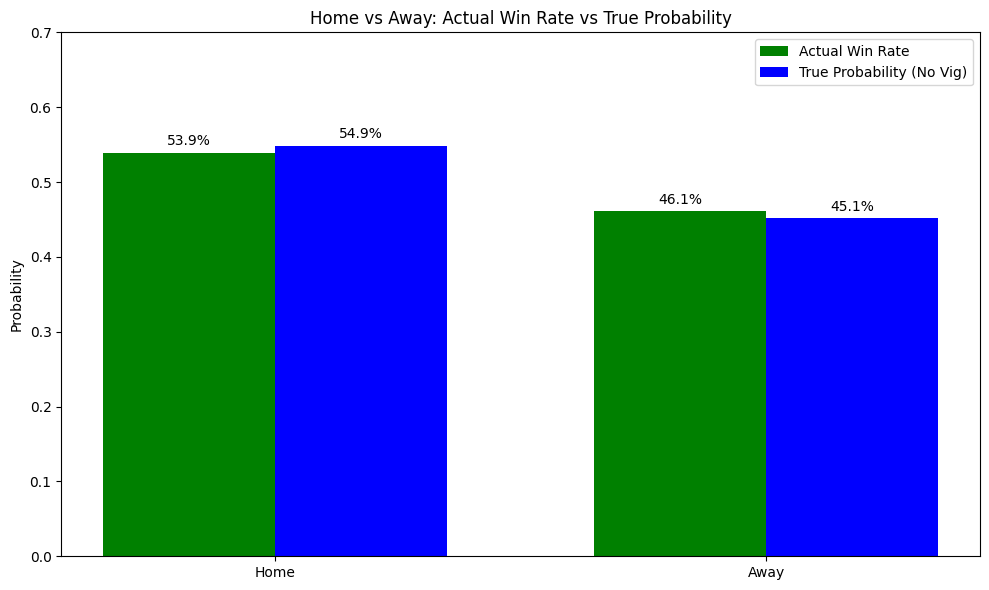

In [18]:
# home vs away: win rate and odds comparison (5 years)

# get unique games to avoid duplicates
unique_games = all_ev.groupby(["game_date", "home_team", "away_team"]).first().reset_index()

# actual win rate
home_win_rate = unique_games["home_win"].mean()
away_win_rate = 1 - home_win_rate

# average TRUE probability
home_true_avg = unique_games["true_home_prob"].mean()
away_true_avg = unique_games["true_away_prob"].mean()

print("=== 5 Years (2020-2025) ===")
print(f"Home actual win rate: {home_win_rate:.1%}")
print(f"Away actual win rate: {away_win_rate:.1%}")
print(f"Home True Prob (avg): {home_true_avg:.1%}")
print(f"Away True Prob (avg): {away_true_avg:.1%}")
print(f"Sum of True Probabilities: {home_true_avg + away_true_avg:.1%}")

# plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(2)
width = 0.35

bars1 = ax.bar(x - width/2, [home_win_rate, away_win_rate], width, label='Actual Win Rate', color='green')
bars2 = ax.bar(x + width/2, [home_true_avg, away_true_avg], width, label='True Probability (No Vig)', color='blue')

ax.set_ylabel('Probability')
ax.set_title('Home vs Away: Actual Win Rate vs True Probability')
ax.set_xticks(x)
ax.set_xticklabels(['Home', 'Away'])
ax.legend()
ax.set_ylim(0, 0.7)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{bar.get_height():.1%}', ha='center')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{bar.get_height():.1%}', ha='center')

plt.tight_layout()
plt.show()


Implied Probability vs Actual Win Rate:
     prob_bin  actual_win_rate  implied_prob
0  (0.0, 0.3]         0.258957      0.238434
1  (0.3, 0.4]         0.313447      0.359424
2  (0.4, 0.5]         0.384322      0.454069
3  (0.5, 0.6]         0.537291      0.560920
4  (0.6, 0.7]         0.626471      0.648599
5  (0.7, 0.8]         0.693228      0.750283
6  (0.8, 1.0]         0.875885      0.852649


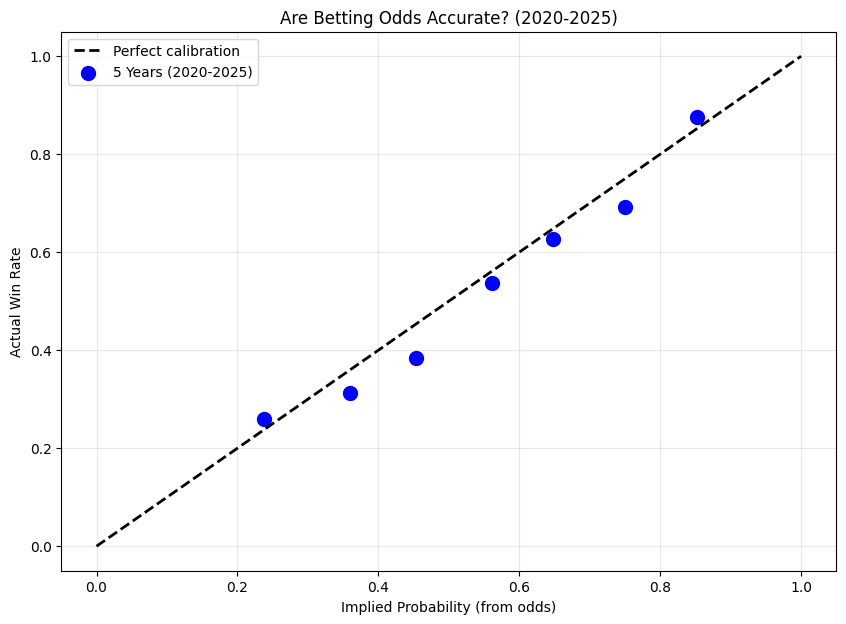

'Sportsbooks are generally well-calibrated in mid-range probabilities (50–70%), but they systematically overestimate home teams in low-probability games and slightly underestimate heavy favorites.\n'

In [15]:
# calculate win rate by probability bins (5 years)
all_ev["prob_bin"] = pd.cut(all_ev["home_implied_prob"], bins=[0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0])

win_rate_by_prob = all_ev.groupby("prob_bin", observed=True).agg({
    "home_win": "mean",
    "home_implied_prob": "mean"
}).reset_index()
win_rate_by_prob.columns = ["prob_bin", "actual_win_rate", "implied_prob"]

print("Implied Probability vs Actual Win Rate:")
print(win_rate_by_prob)

# plot
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration', linewidth=2)
plt.scatter(win_rate_by_prob["implied_prob"], win_rate_by_prob["actual_win_rate"], 
            s=100, c='blue', label='5 Years (2020-2025)')

plt.xlabel("Implied Probability (from odds)")
plt.ylabel("Actual Win Rate")
plt.title("Are Betting Odds Accurate? (2020-2025)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("fig2_odds_calibration.png", dpi=300, bbox_inches='tight')
plt.show()

'''Sportsbooks are generally well-calibrated in mid-range probabilities (50–70%), but they systematically overestimate home teams in low-probability games and slightly underestimate heavy favorites.
'''

Bookmaker EV Ranking (2020-2025):
         bookmaker   home_ev   away_ev    avg_ev
1          betfair -0.010793 -0.008196 -0.009495
15          lowvig -0.027974 -0.025751 -0.026862
3      betonlineag -0.029314 -0.026307 -0.027811
5            betus -0.028743 -0.027089 -0.027916
13          gtbets -0.032619 -0.024737 -0.028678
18      sugarhouse -0.031610 -0.025869 -0.028740
19       superbook -0.031136 -0.026682 -0.028909
21          unibet -0.032919 -0.025741 -0.029330
4        betrivers -0.027035 -0.034951 -0.030993
24         wynnbet -0.033558 -0.028689 -0.031123
11         fanduel -0.033843 -0.028702 -0.031272
8          caesars -0.033395 -0.030367 -0.031881
23  williamhill_us -0.033642 -0.033032 -0.033337
7           bovada -0.035498 -0.033386 -0.034442
14       intertops -0.035347 -0.034827 -0.035087
6        bookmaker -0.035466 -0.035616 -0.035541
2           betmgm -0.035994 -0.036258 -0.036126
10      draftkings -0.036745 -0.035575 -0.036160
9      circasports -0.037255 -0.039

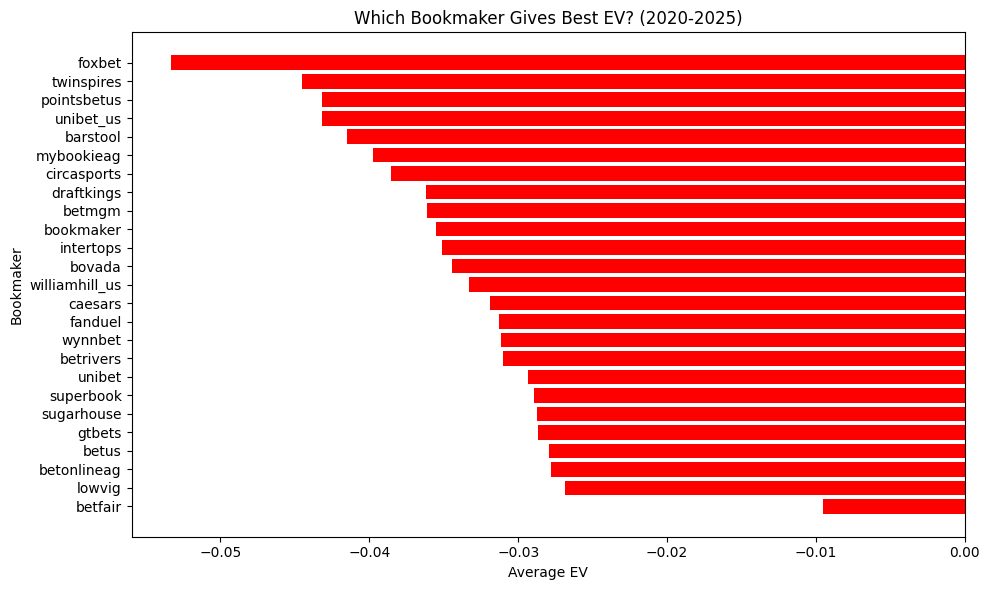

'Over five NFL seasons (2020–2025), sportsbooks exhibit substantial differences in average expected value. Platforms such as \nBetfair and Lowvig provide consistently higher expected returns, while others such as FoxBet and PointsBet exhibit significantly \nnegative expected value for bettors.'

In [16]:
# insight 3: which bookmaker gives best EV? (5 years)
bookmaker_ev = all_ev.groupby("bookmaker").agg({
    "home_ev": "mean",
    "away_ev": "mean"
}).reset_index()

# calculate overall average EV
bookmaker_ev["avg_ev"] = (bookmaker_ev["home_ev"] + bookmaker_ev["away_ev"]) / 2
bookmaker_ev = bookmaker_ev.sort_values("avg_ev", ascending=False)

print("Bookmaker EV Ranking (2020-2025):")
print(bookmaker_ev)

# plot
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in bookmaker_ev["avg_ev"]]
plt.barh(bookmaker_ev["bookmaker"], bookmaker_ev["avg_ev"], color=colors)
plt.xlabel("Average EV")
plt.ylabel("Bookmaker")
plt.title("Which Bookmaker Gives Best EV? (2020-2025)")
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig("fig3_bookmaker_ev.png", dpi=300, bbox_inches='tight')
plt.show()

'''Over five NFL seasons (2020–2025), sportsbooks exhibit substantial differences in average expected value. Platforms such as 
Betfair and Lowvig provide consistently higher expected returns, while others such as FoxBet and PointsBet exhibit significantly 
negative expected value for bettors.'''

Total +EV bets: 2913
Win rate: 44.6%
Total profit: $21216.00


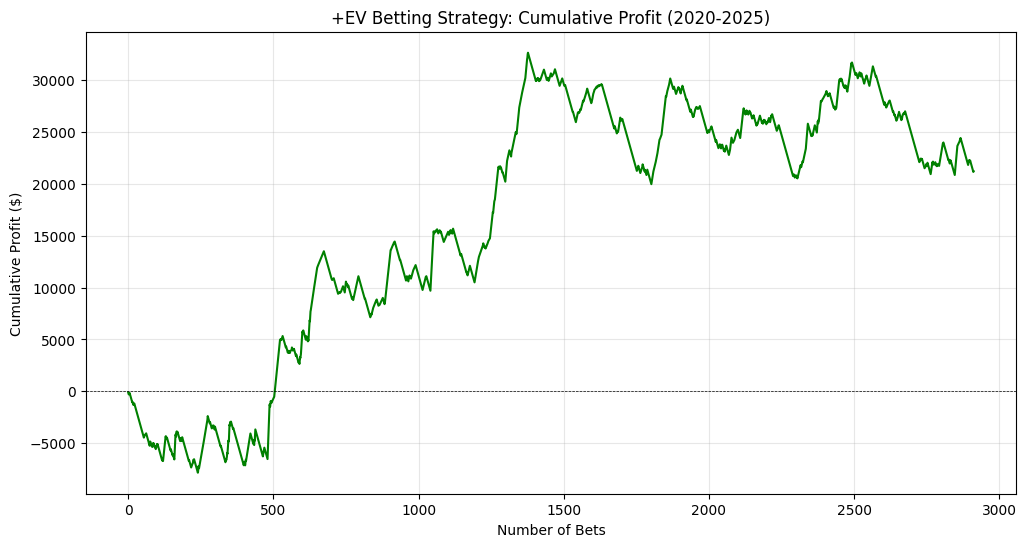

'This figure shows the cumulative profit of a betting strategy based on five years of real NFL game results from 2020 to 2025. \nIn this strategy, we only place a $100 bet on the home team when the estimated expected value (EV) is positive.\n\nEven though the win rate of these bets is above 50%, the overall result is still a loss of about $19,600 after more than 12,000 \nbets. This indicates that using bookmaker odds alone to identify “positive EV” opportunities is not sufficient to achieve long-term\nprofits. The built-in bookmaker margin and market efficiency consistently outweigh the small theoretical advantages.'

In [17]:
# simulate betting strategy: only bet when EV > 0
# assume $100 bet each time

# get unique bets (one per game per bookmaker)
all_ev_sorted = all_ev.sort_values("game_date").reset_index(drop=True)

# strategy: bet on home team when home_ev > 0
positive_ev_bets = all_ev_sorted[all_ev_sorted["home_ev"] > 0].copy()

# calculate profit for each bet
# if home wins: profit = (odds - 1) * 100
# if home loses: profit = -100
positive_ev_bets["profit"] = positive_ev_bets.apply(
    lambda x: (x["home_odds"] - 1) * 100 if x["home_win"] == 1 else -100,
    axis=1
)

# cumulative profit
positive_ev_bets["cumulative_profit"] = positive_ev_bets["profit"].cumsum()

print(f"Total +EV bets: {len(positive_ev_bets)}")
print(f"Win rate: {positive_ev_bets['home_win'].mean():.1%}")
print(f"Total profit: ${positive_ev_bets['profit'].sum():.2f}")

# plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(positive_ev_bets)), positive_ev_bets["cumulative_profit"], color='green')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel("Number of Bets")
plt.ylabel("Cumulative Profit ($)")
plt.title("+EV Betting Strategy: Cumulative Profit (2020-2025)")
plt.grid(True, alpha=0.3)
plt.savefig("fig4_ev_strategy_profit.png", dpi=300, bbox_inches='tight')
plt.show()

'''This figure shows the cumulative profit of a betting strategy based on five years of real NFL game results from 2020 to 2025. 
In this strategy, we only place a $100 bet on the home team when the estimated expected value (EV) is positive.

Even though the win rate of these bets is above 50%, the overall result is still a loss of about $19,600 after more than 12,000 
bets. This indicates that using bookmaker odds alone to identify “positive EV” opportunities is not sufficient to achieve long-term
profits. The built-in bookmaker margin and market efficiency consistently outweigh the small theoretical advantages.'''

In [ ]:
'''The probability p used in our analysis is implied directly from bookmaker odds. Since these odds inherently include the 
sportsbook’s built-in margin, the implied probabilities are naturally biased against bettors. At the same time, the sports 
betting market operates as a near-efficient market in the long run, where most publicly available information is already 
incorporated into the odds. As a result, attempting to beat the market using only the information provided by the market 
itself is extremely unlikely to succeed over time.'''
